<a href="https://colab.research.google.com/github/YaninaK/churn-prediction/blob/main/notebooks/02_Baseline_model_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование оттока клиентов
## Базовая нейросетевая модель

## [EDA и отбор признаков](https://github.com/YaninaK/churn-prediction/blob/main/notebooks/01_EDA_and_Feature_selection.ipynb)

[Ссылка на данные](https://drive.google.com/file/d/1TAVECAfnel9lPfcpfel6qXhZSW2yNqdX/view?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/YaninaK/churn-prediction.git -q

In [3]:
%cd churn-prediction

/content/churn-prediction


In [4]:
import sys
import os

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), "src", "churn_prediction"))

In [5]:
import joblib
import tempfile

import pandas as pd
import numpy as np
import tensorflow as tf

from data.make_dataset import load_data
from data.validation import train_test_data_split
from models import train
from models.LSTM_embeddings_model import get_LSTM_model
from models.inference_tools import preprocessing_pipeline
from models.utilities import (
    get_initial_bias_and_class_weight,
    plot_loss,
    plot_metrics,
    plot_cm,
    plot_roc,
    plot_prc,
    plot_lift,
)

import matplotlib.pyplot as plt

In [6]:
PATH = '/content/drive/MyDrive/ML_projects/06_Churn_prediction/'

## 1. Загрузка данных

In [7]:
data = load_data(PATH)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20468 entries, 0 to 20467
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   20468 non-null  int64  
 1   annualincome                          20468 non-null  int64  
 2   calldroprate                          20468 non-null  float64
 3   callfailurerate                       20468 non-null  float64
 4   callingnum                            20468 non-null  int64  
 5   customerid                            20468 non-null  int64  
 6   customersuspended                     20468 non-null  object 
 7   education                             20468 non-null  object 
 8   gender                                20468 non-null  object 
 9   homeowner                             20468 non-null  object 
 10  maritalstatus                         20468 non-null  object 
 11  monthlybilledam

## 2. Подготовка данных

In [8]:
data_train, data_test = train_test_data_split(data)

In [9]:
(
    lstm_artifacts, nn_model_dataset, selected_features,
) = train.data_preprocessing_pipeline(data_train)

[seq_train, seq_valid, scaler_lstm] = lstm_artifacts
[X_train, X_valid, y_train, y_valid] = nn_model_dataset

In [10]:
train_features = [
    seq_train,
    X_train["state"],
    X_train["education"],
    X_train["occupation"],
    X_train[selected_features],
]
valid_features = [
    seq_valid,
    X_valid["state"],
    X_valid["education"],
    X_valid["occupation"],
    X_valid[selected_features],
]
train_labels = y_train
valid_labels = y_valid

Модель имеет 5 входов:

* Вход для блока LSTM, размерностью (-1, 3, 2):
  - 3 - длина последовательности (3 месяца),
  - 2 - число признаков (totalcallduration и avgcallduration)

* Вход для получения ембеддингов признака state

* По одному входу для one-hot encoding признаков education и occupation

* Вход для остальных отoбранных признаков:
  - категориальные

    * customersuspended,
    * gender,
    * homeowner,
    * maritalstatus,
    * usesinternetservice,
    * usesvoiceservice

  - численные
    * callfailurerate,
    * numberofcomplaints,
    * age,
    * unpaidbalance    


Строковые переменные кодируются с помощью модуля tensorflow.keras.layers.StringLookup.

Для ембеддингов используется модуль tensorflow.keras.layers.Embedding

One-hot encoding выполняется с помощью встроенной функции в tensorflow.keras.layers.StringLookup.


## 3. Модель

* Выход из блока LSTM конкатенируется с пропущенными через полносвязные слои остальными блоками.
* Объединенный блок еще раз пропускается через полносвязный слой, после чего следует финальный слой.
* В качестве оптимизатора используется tensorflow.keras.optimizers.Adam()
* Функция потерь - tensorflow.keras.losses.BinaryCrossentropy()

In [11]:
vocab_s = X_train['state'].unique().tolist()
n_labels_s = len(vocab_s)
vocab_e = X_train['education'].unique().tolist()
vocab_o = X_train['occupation'].unique().tolist()
n_features_other = len(selected_features)

params = {
    'input_sequence_length': 3,
    'n_features': 2,
    'n_units': 8,
    'vocab_s': vocab_s,
    'n_labels_s': n_labels_s,
    'embedding_size_s': 4,
    'vocab_e': vocab_e,
    'vocab_o': vocab_o,
    'n_features_other': n_features_other,
    'n_units_others': 8,
    'n_units_all': 16,
}

In [12]:
i = 1
model_path = f"models/LSTM_emb_model_v{i}.keras"
history_path = f"models/model_LSTM_emb_training_history_v{i}.joblib"
checkpoints_path = PATH + f'data/06_model_output/initial_weights_{i}'
BATCH_SIZE = 64

regenerate = False
if regenerate:
    initial_bias, class_weight = get_initial_bias_and_class_weight(y_train)
    initial_weights = os.path.join(tempfile.mkdtemp(), checkpoints_path)

    lstm_model = get_LSTM_model(**params, output_bias=initial_bias)
    lstm_model.load_weights(initial_weights)

    n_epochs = 200
    batch_size = BATCH_SIZE
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 3e-2 * 0.95**epoch
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_prc",
        patience=50,
        min_delta=1e-06,
        verbose=1,
        mode="max",
        restore_best_weights=True,
    )

    history = lstm_model.fit(
        train_features,
        train_labels,
        epochs=n_epochs,
        validation_data=(valid_features, valid_labels),
        class_weight=class_weight,
        batch_size=batch_size,
        verbose=0,
        callbacks=[reduce_lr, early_stopping],
        shuffle=True,
        workers=-1,
        use_multiprocessing=True,
    )
    lstm_model.save(PATH + model_path)
    joblib.dump(history, PATH + history_path)
else:
    lstm_model = tf.keras.models.load_model(PATH + model_path)
    history = joblib.load(PATH + history_path)

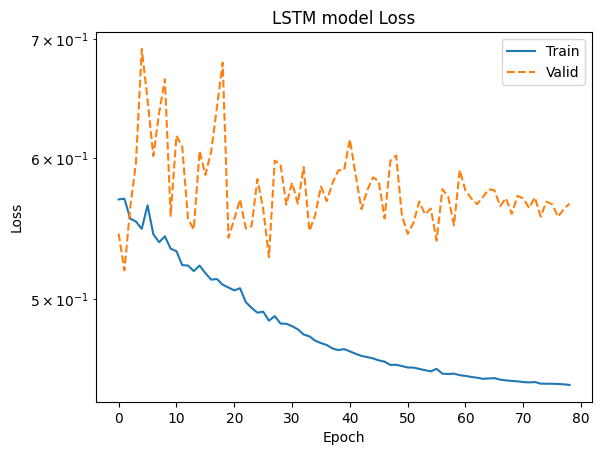

In [13]:
plot_loss(history)

In [14]:
results = lstm_model.evaluate(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    verbose=0
)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.5567


In [15]:
baseline_results = lstm_model.evaluate(
    valid_features,
    valid_labels,
    batch_size=BATCH_SIZE,
    verbose=0
)
for name, value in zip(lstm_model.metrics_names, baseline_results):
  print(f'{name} : {value}')

loss : 0.5426945686340332
cross entropy : 0.5426945686340332
Brier score : 0.19039303064346313
tp : 164.0
fp : 701.0
tn : 1393.0
fn : 40.0
accuracy : 0.6775456666946411
precision : 0.18959537148475647
recall : 0.8039215803146362
auc : 0.8047829866409302
prc : 0.25213623046875


AUC на валидационном сете 0.8048, что значительно выше, чем в базовом варианте Random Forest 0.7051.

In [16]:
lstm_model.save_weights(checkpoints_path)

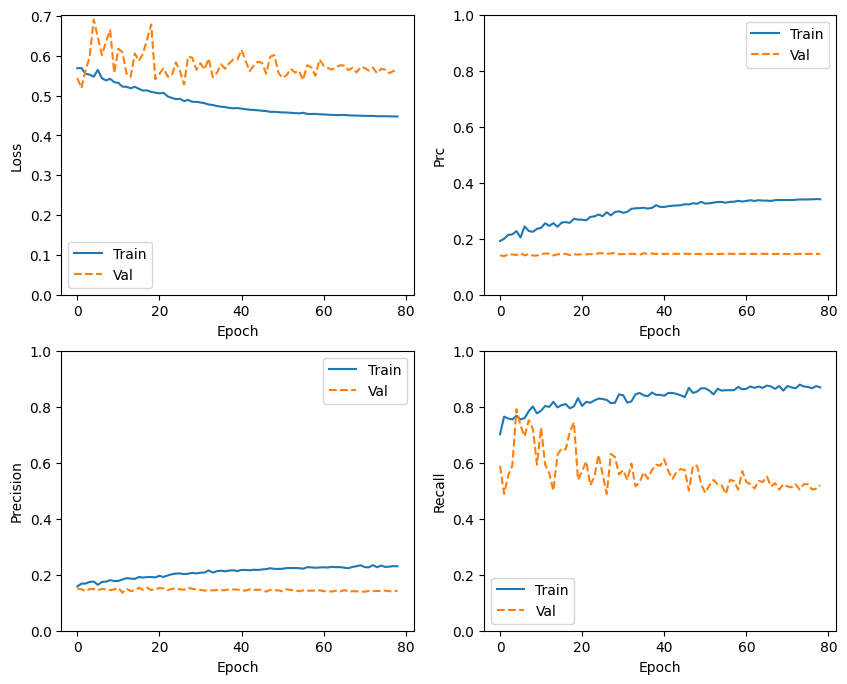

In [17]:
plot_metrics(history)

* Поскольку модель была предобученная, изменений Precision от эпохи к эпохе на валидационном сете графике не видно.

## 4. Оценка модели

In [18]:
test_features, test_labels = preprocessing_pipeline(data_test)

In [19]:
train_predictions_baseline = lstm_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = lstm_model.predict(test_features, batch_size=BATCH_SIZE)

30/30 [==============================] - 0s 3ms/step


### 4.1 Confusion matrix

No churn Detected (True Negatives):  3189
No churn Incorrectly Detected (False Positives):  1696
Churn Missed (False Negatives):  93
Churn Detected (True Positives):  382
Total Fraudulent Transactions:  475


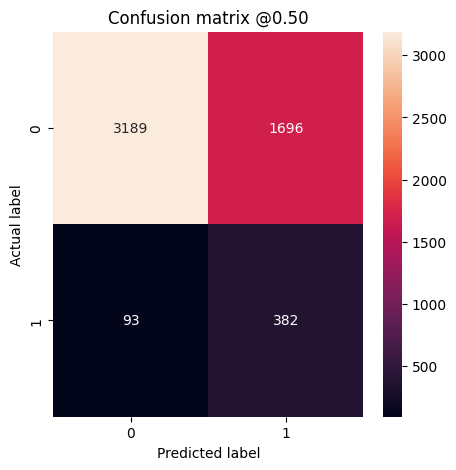

In [20]:
plot_cm(train_labels, train_predictions_baseline)

loss :  0.5514865517616272
cross entropy :  0.5514865517616272
Brier score :  0.19421622157096863
tp :  143.0
fp :  563.0
tn :  1122.0
fn :  39.0
accuracy :  0.6775575876235962
precision :  0.20254957675933838
recall :  0.7857142686843872
auc :  0.805473268032074
prc :  0.2794499695301056


No churn Detected (True Negatives):  1122
No churn Incorrectly Detected (False Positives):  563
Churn Missed (False Negatives):  39
Churn Detected (True Positives):  143
Total Fraudulent Transactions:  182


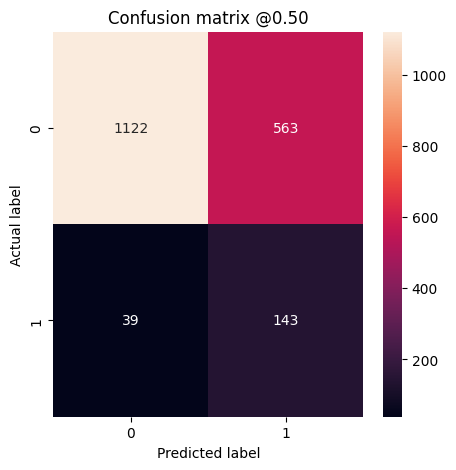

In [21]:
baseline_results = lstm_model.evaluate(
    test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(lstm_model.metrics_names, baseline_results):
  print(name, ': ', value)
print('\n')
plot_cm(test_labels, test_predictions_baseline)

No churn Detected (True Negatives):  947
No churn Incorrectly Detected (False Positives):  738
Churn Missed (False Negatives):  22
Churn Detected (True Positives):  160
Total Fraudulent Transactions:  182


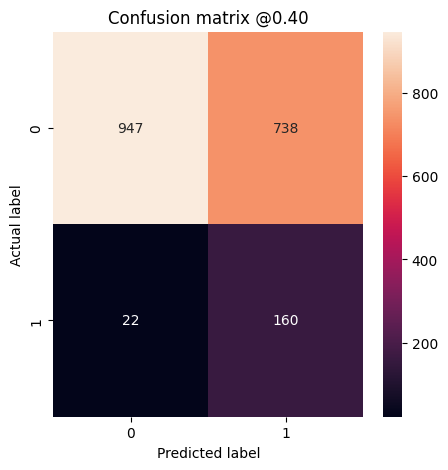

In [22]:
plot_cm(test_labels, test_predictions_baseline, threshold=0.4)

* В зависимости от стоимости обработки False Positive результатов, можно установить другую точку отсечения положительных от отрицательных результатов, отличную от 0.5. Например, при точке отсечения 0.4 число правильно предсказанных случаев оттока возросло с 143 до 160, однако число False Positive результатов тоже возросло (с 563 до 738).

### 4.2. ROC - кривая

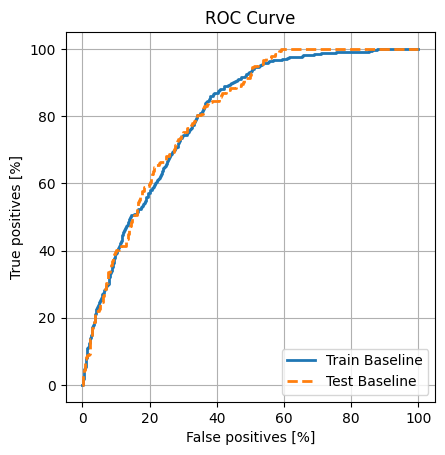

In [23]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, )
plot_roc("Test Baseline", test_labels, test_predictions_baseline, linestyle='--')
plt.legend(loc='lower right');

ROC - кривая на обучающей и тестовой выборках практически совпадает.

### 4.3. Precision-Recall кривая

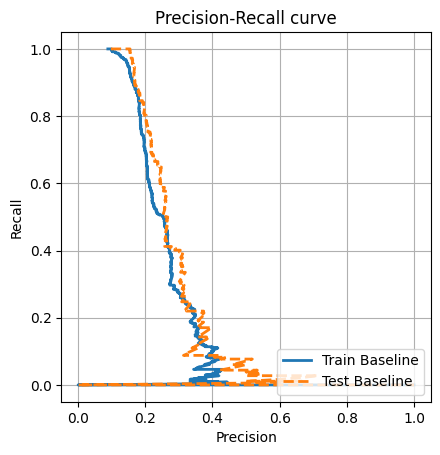

In [24]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline)
plot_prc("Test Baseline", test_labels, test_predictions_baseline, linestyle='--')
plt.legend(loc='lower right');

Precision-Recall кривые на обучающей и тестовой выборках достаточно близки.

### 4.4. Лифт модели

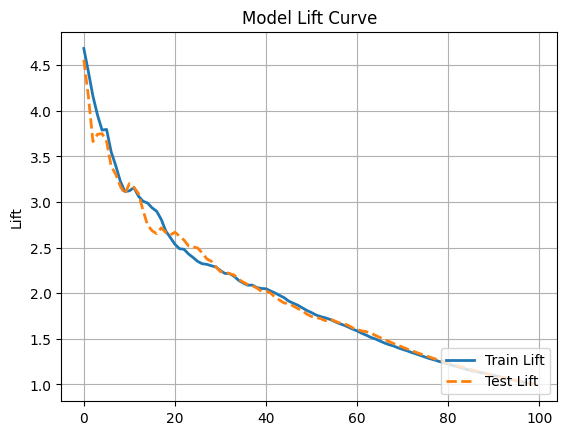

In [25]:
plot_lift("Train Lift", train_labels, train_predictions_baseline)
plot_lift("Test Lift", test_labels, test_predictions_baseline, linestyle='--')
plt.legend(loc='lower right');

У модели неплохой лифт. Имеет смысл проанализировать, с какими группами клиентов она работает лучше и сконцентрироваться на них, чтобы минимизировать расходы на обработку False Positive результатов.

### 4.5. Оценка по возрастным группам

In [26]:
data = load_data(PATH)
_, data_test = train_test_data_split(data)

data_test = data_test[data_test['age'] > 43]
test_features, test_labels = preprocessing_pipeline(data_test, PATH)

baseline_results = lstm_model.evaluate(
    test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(lstm_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

loss :  0.35449928045272827
cross entropy :  0.35449928045272827
Brier score :  0.11654866486787796
tp :  54.0
fp :  173.0
tn :  758.0
fn :  12.0
accuracy :  0.8144433498382568
precision :  0.2378854602575302
recall :  0.8181818127632141
auc :  0.9051118493080139
prc :  0.3034866750240326



In [27]:
data = load_data(PATH)
_, data_test = train_test_data_split(data)

data_test = data_test[data_test['age'] <= 43]
test_features, test_labels = preprocessing_pipeline(data_test, PATH)

baseline_results = lstm_model.evaluate(
    test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(lstm_model.metrics_names, baseline_results):
  print(name, ': ', value)

loss :  0.777229368686676
cross entropy :  0.777229368686676
Brier score :  0.2832214832305908
tp :  89.0
fp :  390.0
tn :  364.0
fn :  27.0
accuracy :  0.5206896662712097
precision :  0.18580375611782074
recall :  0.767241358757019
auc :  0.6774958372116089
prc :  0.2838902175426483


* Модель хорошо срабатывает на клиентах старше 43 лет (AUC: 0.9051) и больше ошибается на молодых клиентах (AUC: 0.6775). Для молодых клиентов имеет смысл подумать над дополнительными разделяющими признаками или простроить дополнительную модель, которая бы работала с ошибкой или делала бы самостоятельные предсказания.